## Task:-

1) Use a sample size of 100k datapoints and apply Truncated-SVD on TFIDF

2) Take top 2000 or 3000 features from tfidf vectorizers using idf_score

3) calculate co-occurrence matrix

4) choose n_components in truncated svd with maximum explained variance.

5) Apply k-means clustering and choose best number of clusters based on elbow method

6) print out word clouds for each cluster 

7) write a function that takes a word and returns most similar words using cosine similarity

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2). 

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [02:56<00:00, 496.24it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
pd.options.display.width = None

final['Summary'].head(5000)


22620                                        made in china
22621                                    Dog Lover Delites
70677                              only one fruitfly stuck
70676              Doesn't work!! Don't waste your money!!
70675                                        A big rip off
70673               THIS ITEM IS EXCELLENT TO KILL INSECTS
70672                                          Didn't work
70671                                  Gross but effective
70670                                  Didn't work for me.
70669                                       Waste of money
70668          I should read those reviews before ordered.
70661                            Doesn't catch fruit flies
70667                              Complete Waste of Money
70666                                               RIpoff
70665                                            It's junk
70662                                Worthless Indoor Trap
70663              Epic Fail - Worst Fly Trap Ever Creat

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)



made in china
Not much taste
hot stuff
Great value


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

made in china


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

made in china
Not much taste
hot stuff
Great value


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"I've","i have",phrase)
    phrase = re.sub(r"Don't","do not",phrase)
    phrase = re.sub(r"It's","it is",phrase)
    phrase = re.sub(r"wouldn't","would not",phrase)
    phrase = re.sub(r"You'll","you will",phrase)
    phrase = re.sub(r"Doesn't","does not",phrase)
    phrase = re.sub(r"They're","they are",phrase)
    phrase = re.sub(r"That's","that is",phrase)
    phrase = re.sub(r"didn't","did not",phrase)
    phrase = re.sub(r"Doesn't","does not",phrase)
    phrase = re.sub(r"you're","you are",phrase)
    phrase = re.sub(r"That's","that is",phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

hot stuff


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

made in china


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

hot stuff


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews1 = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews1.append(sentance.strip())

100%|██████████| 87773/87773 [02:14<00:00, 654.09it/s] 


In [34]:
preprocessed_reviews1[1500]

'hot stuff'

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [36]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [37]:
tf_idf_vect = TfidfVectorizer(max_features = 2000)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'across', 'actual', 'actually', 'add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 2000)
the number of unique words including both unigrams and bigrams  2000


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [38]:
#top features of the tfidf model
indices = np.argsort(tf_idf_vect.idf_)[::-1]
topfeatures = np.take(tf_idf_vect.get_feature_names(),indices[0:3000])
print('Top 10 features : ',topfeatures[0:10])

Top 10 features :  ['xylitol' 'mate' 'ketchup' 'chia' 'truffle' 'sardines' 'chops' 'pg'
 'cacao' 'capsules']


In [39]:
# Get feature names from tfidf
features = tf_idf_vect.get_feature_names()
# feature weights based on idf score
coef = tf_idf_vect.idf_
# Store features with their idf score in a dataframe
coeff_df = pd.DataFrame({'Features' : features, 'Idf_score' : coef})
coeff_df = coeff_df.sort_values("Idf_score", ascending = True)[:2000]
print("shape of selected features :", coeff_df.shape)
print("Top 10 features :\n\n",coeff_df[0:10])

shape of selected features : (2000, 2)
Top 10 features :

      Features  Idf_score
1144      not   1.605378
980      like   2.198111
753      good   2.312714
769     great   2.412216
1181      one   2.500359
1754    taste   2.516372
1976    would   2.591810
1357  product   2.653863
1014     love   2.681394
671    flavor   2.697065


### [5.2] Calulation of Co-occurrence matrix

In [40]:
#https://github.com/saugatapaul1010/Amazon-Fine-Food-Reviews-Analysis/blob/master/16.%20%20Truncated%20SVD.ipynb
#Generate the Co-Occurence Matrix
def get_coOccuranceMatrix(X_train, top_features, window): #window = 2 means 2 on either side of the given word. Lets look at an example. data = [a,b,c,d,e,f,g,h],
    print("Generating the Co Occurence Matrix....")       #if window = 2, for letter c, we will have neighborhood = [a,b,c,d,e]. for f -> [d,e,f,g,h]
    dim=top_features.shape[0] #taking all rows in top features
    square_matrix = np.zeros((dim,dim),int) 
    
    values = [i for i in range(0,topfeatures.shape[0])]  #Contains all the top TF-IDF Scores as values.
    keys = [str(i) for i in topfeatures]    #Contains all the corresponding features names as keys.
    lookup_dict = dict(zip(keys,values))                  #We will use this dictionary as a look up table 

    top_words= keys
    
    #Processing each reviews to build the co-occurence Matrix
    for reviews in tqdm(X_train):
        #Split each review into words
        words = reviews.split()
        lnt = len(words)
        for i in range(0,len(words),1):
            idx_of_neigbors= []
            if((i-window >= 0) and (i+window < lnt)):
                idx_of_neigbors = np.arange(i-window,i+window+1)
            elif((i-window < 0) and (i+window < lnt)): 
                idx_of_neigbors = np.arange(0, i+window+1)
            elif((i-window >= 0) and (i+window >= lnt)):
                idx_of_neigbors = np.arange(i-window, lnt)
            else:
                pass
            #nei = [words[x] for x in idx_of_neigbors]
            #print(words[i],"---------",nei)
            #print(idx_of_neigbors)
            
            for j in idx_of_neigbors:
                if((words[j] in top_words) and (words[i] in top_words)):
                    row_idx = lookup_dict[words[i]]     #Get the index of the ith word from the lookup table
                    col_idx = lookup_dict[words[j]]     #Get the index of the jth word from the lookup table
                    square_matrix[row_idx,col_idx] += 1 #If word[i] and word[j] occurs in a neighbourhood of 5, there co occurence will be increases by one.
                else:
                    pass
                    
    #Fill all the diagonal elements of the co-occurence matrix with 0, as co-occurence of a word with itlself is always zero.                
    np.fill_diagonal(square_matrix, 0) 
    print("Co Occurence Matrix is generated....")      
    
    #Create a co-occurence dataframe.
    co_occur_df=pd.DataFrame(data=square_matrix, index=keys, columns=keys)
    return co_occur_df

co_occur_matrix = get_coOccuranceMatrix(preprocessed_reviews, topfeatures, window=2)


Generating the Co Occurence Matrix....


100%|██████████| 87773/87773 [59:14<00:00, 10.82it/s]  


Co Occurence Matrix is generated....


In [41]:
print(co_occur_matrix)

             xylitol  mate  ketchup  chia  truffle  sardines  chops  pg  \
xylitol            0     0        0     0        0         0      0   0   
mate               0     0        0     0        0         0      0   0   
ketchup            0     0        0     0        0         0      0   0   
chia               0     0        0     0        0         0      0   0   
truffle            0     0        0     0        0         0      0   0   
sardines           0     0        0     0        0         0      0   0   
chops              0     0        0     0        0         0      0   0   
pg                 0     0        0     0        0         0      0   0   
cacao              0     0        0     0        0         0      0   0   
capsules           0     0        0     0        0         0      0   0   
feast              0     0        0     0        0         0      0   0   
tofu               0     0        0     0        0         0      0   0   
frosting           0     

[2000 rows x 2000 columns]


### [5.3] Finding optimal value for number of components (n) to be retained.

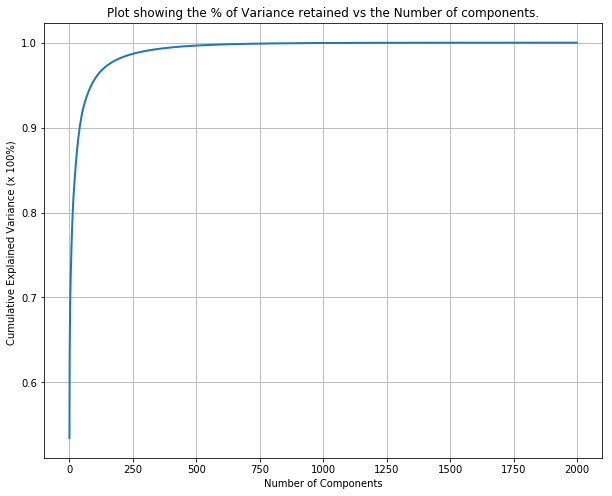

In [42]:
from sklearn.decomposition import TruncatedSVD
n = co_occur_matrix.shape[0]-1

#Inititalize the truncated SVD object.
tsvd = TruncatedSVD(n_components=n, 
                   algorithm='randomized', 
                   n_iter=10, 
                   random_state=0)
data=tsvd.fit_transform(co_occur_matrix)

cum_var_explained = np.cumsum(tsvd.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(10, 8))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.title('Plot showing the % of Variance retained vs the Number of components.')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (x 100%) ')
plt.show()

In [43]:
# TruncatedSVD
# From the above Cumulative Variance Plot, it can be understood that,
# with n_components = 2000, more than 95% of variance is explained.


from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
data=svd.fit_transform(co_occur_matrix)
#+# print(data_1000.shape)

## Normalizing Data

In [44]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(data)
print(standardized_data_train.shape)



(2000, 500)


### [5.4] Applying k-means clustering

In [45]:
# https://www.kaggle.com/vjchoudhary7/kmeans-clustering-in-customer-segmentation
# https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
    kmeans.fit(standardized_data_train)
    loss.append(kmeans.inertia_)
    
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart

100%|██████████| 9/9 [00:34<00:00,  3.37s/it]


[[ 5.66683919e-01 -2.78888468e-02  4.04710366e-02 ... -4.61120956e-04
  -2.32617595e-03 -2.27082713e-03]
 [ 7.41872281e-01 -3.29004842e-01  3.93938869e-04 ... -3.16280015e-04
   1.24722713e-03  1.01785910e-03]
 [ 4.29899110e-01 -8.19913106e-02 -2.65073136e-02 ...  5.04145249e-03
   3.25749627e-03 -4.59744683e-03]
 ...
 [ 6.87413614e-01 -9.79727838e-03  9.59422968e-02 ... -3.18098385e-04
  -2.23220448e-04 -2.02613578e-03]
 [ 6.03537507e-01 -1.67462175e-02 -1.09696919e-01 ...  2.79633613e-04
   1.34446856e-03 -1.31009809e-03]
 [ 7.24137309e-01 -5.46611655e-02 -4.03131796e-02 ... -6.91331789e-04
  -2.64957104e-04  1.65184683e-03]]


### Plotting a graph K vs  Inertia

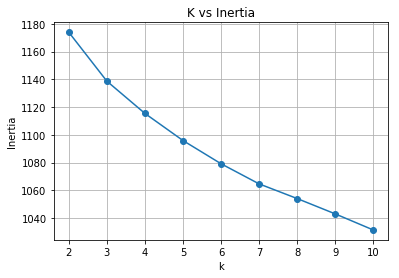

In [46]:
plt.plot(k_values,loss,marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("K vs Inertia")
plt.grid()
plt.show()

In [47]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
kmeans.fit(standardized_data_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [48]:
coeff_df1=[str(i) for i in topfeatures]
lables = list(set(kmeans.labels_))
clusters = []
for i in lables:
    temp = []
    for j in range(kmeans.labels_.shape[0]):
        if kmeans.labels_[j] == i:
            temp.append(coeff_df1[j])
    clusters.append(temp)

In [49]:
print(clusters)

[['capsules', 'canidae', 'win', 'tray', 'cap', 'jug', 'lick', 'ups', 'pills', 'rolls', 'dad', 'purina', 'pill', 'inch', 'owners', 'brother', 'moisture', 'comments', 'flowers', 'squeeze', 'method', 'wholesome', 'plate', 'drain', 'interest', 'step', 'dozen', 'remaining', 'kitty', 'happens', 'digestion', 'instantly', 'wont', 'reach', 'split', 'mexican', 'bowls', 'slow', 'info', 'adults', 'walk', 'earlier', 'space', 'broke', 'trips', 'chose', 'commercial', 'scoop', 'separate', 'holiday', 'farms', 'switching', 'response', 'terrier', 'orders', 'club', 'road', 'eye', 'pleasure', 'eventually', 'preferred', 'yesterday', 'lucky', 'faster', 'kernels', 'possibly', 'consistently', 'workout', 'helping', 'moment', 'current', 'success', 'crushed', 'smart', 'noted', 'example', 'jack', 'tummy', 'discontinued', 'shows', 'rarely', 'pocket', 'toss', 'favor', 'anytime', 'initially', 'visit', 'guys', 'economical', 'solution', 'storage', 'finicky', 'household', 'effort', 'sizes', 'packing', 'refrigerator', 'd

In [50]:
def cluster_wordcloud_generated_image_fun(words_list):
    wordcloud = WordCloud(max_words=len(clusters[i]),background_color="white",width=1080, height=720,min_font_size = 10, collocations=False).generate(" ".join(words_list))
    plt.figure(figsize=(10,10))
    print ("\n\nWord Cloud for Important features")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Cluster =  1 -- No of words = 640


Word Cloud for Important features


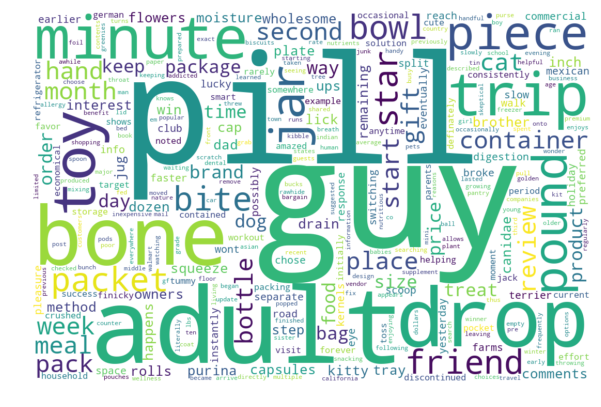


Cluster =  2 -- No of words = 430


Word Cloud for Important features


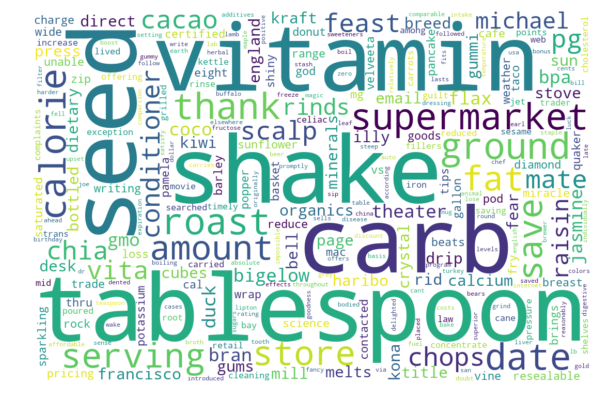


Cluster =  3 -- No of words = 506


Word Cloud for Important features


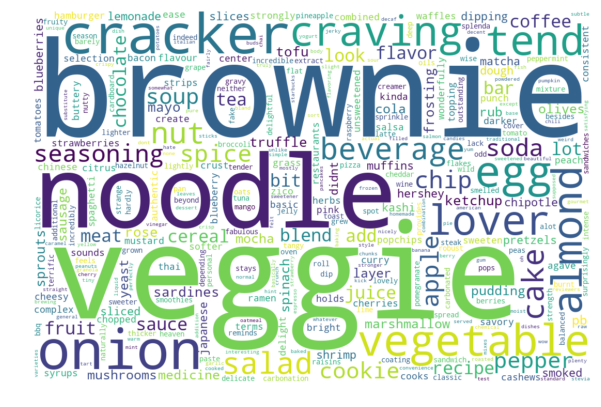


Cluster =  4 -- No of words = 424


Word Cloud for Important features


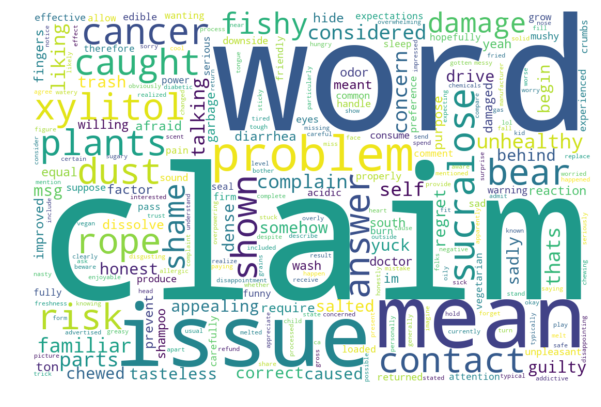

In [51]:
# Printing out wordclouds for each cluster
from wordcloud import WordCloud 

for i in lables:
    print("\nCluster = ",i+1,"-- No of words =",len(clusters[i]))
    if len(clusters[i]) < 2 :
        print(clusters[i])
    else :
        cluster_wordcloud_generated_image_fun(clusters[i])

### [5.6] Function that returns most similar words for a given word.

In [52]:
from numpy.linalg import norm

#Insteadd of selecting word i am randomly taking one worf from top words
word = np.random.choice(topfeatures)
print('The word is ',word)


def cosine(A,B):
    return np.dot(A,B) / (norm(A) * norm(B))

#word vector of the word
if word in topfeatures:
    word_index = np.where(topfeatures == word)
    word_vector = data[word_index]
else:
    print('Word not in feature array')
    
#Calculating cosine similarity of word vectors
word_similarity = []
for i in data:
    word_similarity.append(cosine(word_vector,i))

#top similar words limiting to 10
top_sim = sorted(word_similarity,reverse=True)[0:10]
similar_words = []
for i in top_sim:
    similar_words.append(topfeatures[np.where(word_similarity == i)[0]][0])
print('Words similar to the word %s are %s' %(word,similar_words))


The word is  thai
Words similar to the word thai are ['thai', 'chinese', 'restaurants', 'homemade', 'restaurant', 'mexican', 'general', 'prepared', 'japanese', 'also']


Here i am concluding the above words are giving similar words to randomly choosen word

## Procedure

#steps Involved

1) Connecting SQL file 

2) Taking 1st 100K Rows (Due to low Ram)

3) Sorting the data based on time

4) Data Cleaning

5) Preprocessing 

6) Techniques For Vectorization Bow,TF-IDF.

7) Taking top 3000 features from tfidf vectorizers using idf_score

8) calculating co-occurrence matrix

9) choosing n_components in truncated svd with maximum explained variance.

10) Applying k-means clustering and choose best number of clusters based on elbow method

11) printing out word clouds for each cluster 

12) writing a function that takes a word and returns most similar words using cosine similarity





